In [23]:
from sde_lib import *

In [24]:
sdeve = VESDE(sigma_min=0.01, sigma_max=50, N = 1000)

In [25]:
x = torch.ones((1,1,32,32))
xt = vesde.forward_sampling(x,1)

In [32]:
xt1 = x + sdeve.discrete_sigmas[999]*torch.randn_like(x)

In [40]:
sdeve.discrete_sigmas[::100]

tensor([1.0000e-02, 2.3457e-02, 5.5022e-02, 1.2906e-01, 3.0274e-01, 7.1013e-01,
        1.6657e+00, 3.9072e+00, 9.1651e+00, 2.1498e+01], dtype=torch.float64)

In [34]:
xt1.std()

tensor(50.4821)

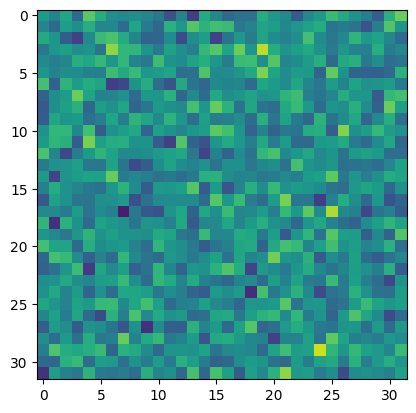

In [37]:
import matplotlib.pyplot as plt
plt.imshow(xt1.reshape((32,32)), vmin = -200, vmax = 200)
plt.show()

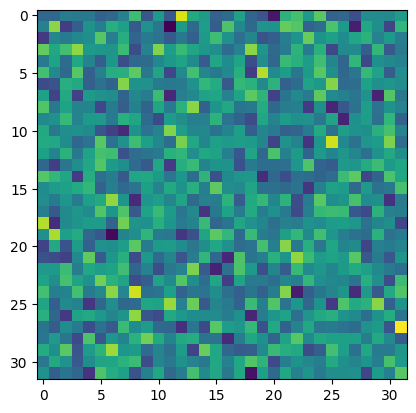

In [19]:
plt.imshow((torch.randn_like(x)).reshape((32,32)))
plt.show()

In [41]:

def batch_mul(a, b):
  return torch.vmap(lambda a, b: a * b)(a, b)

In [65]:
batch = (torch.ones((32,1,32,32))).to("cuda:0")
labels = torch.randint(0, vesde.N, (32,), device="cuda:0")
discrete_sigmas = vesde.discrete_sigmas
sigmas = discrete_sigmas[labels.cpu()].to("cuda:0")
#rng, step_rng = random.split(rng)
noise = torch.randn_like(batch)
scaled_noise = batch_mul(noise, sigmas)
perturbed_data = scaled_noise + batch

In [ ]:
from losses import *

In [ ]:
sdeve = VESDE(sigma_min=0.01, sigma_max=50, N = 1000)

In [ ]:
from configs.ve import ncsnpp_config as ve_ncsnpp_config
from models.ncsnpp import *

In [66]:
batch = torch.ones((32,1,32,32)).to("cuda:0")

In [ ]:
model = (NCSNpp(config)).to(config.device)

In [67]:
sigmas = sdeve.discrete_sigmas
#smld_sigma_array = vesde.discrete_sigmas[::-1]
smld_sigma_array = sigmas
reduce_op = torch.mean

def loss_fn(model, batch):
    model_fn = mutils.get_model_fn(model, train=False)
    #rng, step_rng = random.split(rng)
    #labels = random.choice(step_rng, vesde.N, shape=(data.shape[0],))
    labels = torch.randint(0, sdeve.N, (batch.shape[0],), device=batch.device)
    sigmas = smld_sigma_array[labels.cpu()].to(batch.device)
    sigmas = sigmas.view((batch.shape[0],1,1,1))
    #rng, step_rng = random.split(rng)
    noise = torch.randn_like(batch)
    #scaled_noise = batch_mul(noise, sigmas)
    scaled_noise = (torch.mul(noise, sigmas)).float()
    perturbed_data = scaled_noise + batch
    #rng, step_rng = random.split(rng)
    score = model_fn(perturbed_data, labels)
    print(score)
    #target = -batch_mul(noise, 1. / (sigmas ** 2))
    target = -torch.mul(noise, (1/sigmas**2))
    #target = -batch_mul(noise, (1/sigmas))
    losses = torch.square(score - target)
    #losses = batch_mul(losses, (1/sigmas**2))
    losses = reduce_op(losses.reshape((losses.shape[0], -1)), axis=-1)
    losses = losses * (sigmas ** 2)
    loss = torch.mean(losses)


In [63]:
perturbed_data[17,:,:,:].std()

tensor(35.7448, device='cuda:0')

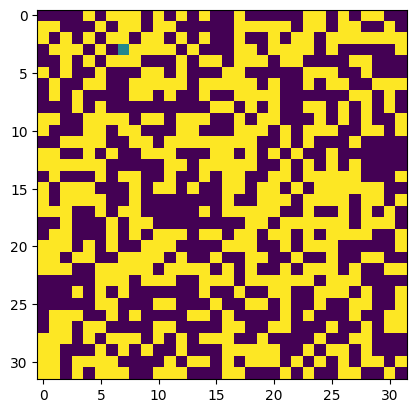

In [64]:
plt.imshow((perturbed_data[6,:,:]).detach().cpu().numpy().reshape((32,32)), vmin = .9, vmax = 1.1)
plt.show()
